<a href="https://colab.research.google.com/github/yurizza/Belajar-Pengembangan-Machine-Learning/blob/main/NLP_bbc_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek NLP: BBC News Classification
- Nama: Cici Yuriza
- Email: ciciyuriza999@gmail.com
- Id Dicoding: yuriza


Goal: Categorizing news into five categories for BBC News, namely **sports, business, politics, technology, and entertainment.**

Dataset: [BBC News Archive Dataset](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive)


Import Library

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define folder path in drive
folder_path = '/content/drive/MyDrive/dicoding/'

In [ ]:
# import library
import numpy as np
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalAveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import Callback

In [ ]:
# unzip folder in drive

# import zipfile

# # define folder path
# zip_file_path = folder_path + 'bbc_news.zip'

# # define folder path for unzip folder
# extracted_folder = folder_path + 'NLP'

# # Create a ZipFile object
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the contents into the specified folder
#     zip_ref.extractall(extracted_folder)

In [ ]:
# read csv file with seperator '\t'
df = pd.read_csv(folder_path + 'NLP/bbc-news-data.csv', sep='\t')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
# show total category
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

5 category for bbc news are sport, business, politics, tech and entertainment.

#### Cleaning Data

In [ ]:
# delete unnecessary column (filename and title)
filtered_df = df.copy()
filtered_df = filtered_df.drop(['filename','title'], axis=1)
filtered_df.head()

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...


In [ ]:
# cek missing value
filtered_df.isnull().sum()

category    0
content     0
dtype: int64

there is no missing value

In [ ]:
# cek duplicate
filtered_df.duplicated().sum()

133

there are 133 duplicated data


In [ ]:
# Mengecek data duplikat
duplicates = filtered_df[filtered_df.duplicated(keep=False)]

# Menampilkan keseluruhan data duplikat
print("Keseluruhan Data Duplikat:")
print(duplicates)


Keseluruhan Data Duplikat:
      category                                            content
6     business   The US created fewer jobs than expected in Ja...
213   business   UK businesses are set to prosper during the n...
214   business   The US stock market watchdog's chairman has s...
239   business   UK businesses are set to prosper during the n...
252   business   The US created fewer jobs than expected in Ja...
...        ...                                                ...
2210      tech   By early 2005 the net could have two new doma...
2211      tech   Four times more mobiles with cameras in them ...
2215      tech   Fast web access is encouraging more people to...
2216      tech   Internet search engine users are an odd mix o...
2221      tech   Computer users across the world continue to i...

[266 rows x 2 columns]


In [ ]:
# show content in row 213
filtered_df.iloc[213,1]

' UK businesses are set to prosper during the next few months - but this could trigger more interest rate rises, according to a report.  Optimism is at its highest since 1997 and business will reap the benefits of a continuing rise in public spending, say researchers at BDO Stoy Hayward. The Bank of England is expected to keep rates on hold this week - but they could go up later in the year. Rates are likely to rise after the anticipated general election in May. The BDO optimism index - a leading indicator of GDP growth two quarters ahead edged up in January to 102.5, from 102.2 in October. The rise is due, in part, to an increase in public spending and increased merger and acquisition activity.  The only thing blighting business optimism this year will be uncertainties associated with the general election, BDO said. Its BDO\'s output index - which predicts GDP movements a quarter in advance - remained at 100.8 for January, implying GDP growth at 2.9% in the second quarter of 2005. How

In [ ]:
# show content in row 239
filtered_df.iloc[239,1]

' UK businesses are set to prosper during the next few months - but this could trigger more interest rate rises, according to a report.  Optimism is at its highest since 1997 and business will reap the benefits of a continuing rise in public spending, say researchers at BDO Stoy Hayward. The Bank of England is expected to keep rates on hold this week - but they could go up later in the year. Rates are likely to rise after the anticipated general election in May. The BDO optimism index - a leading indicator of GDP growth two quarters ahead edged up in January to 102.5, from 102.2 in October. The rise is due, in part, to an increase in public spending and increased merger and acquisition activity.  The only thing blighting business optimism this year will be uncertainties associated with the general election, BDO said. Its BDO\'s output index - which predicts GDP movements a quarter in advance - remained at 100.8 for January, implying GDP growth at 2.9% in the second quarter of 2005. How

In [ ]:
# Menghapus data duplikat
filtered_df = filtered_df.drop_duplicates()

In [ ]:
# cek duplicate
filtered_df.duplicated().sum()

0

there is no missing value

In [ ]:
filtered_df.shape

(2092, 2)

2092 data will be used for the next stage.

#### Preprocessing

In this step, we will remove stop words, remove numbers, convert to lowercase, and remove punctuations.

In [ ]:
# Download the stopwords resource
nltk.download('stopwords')

# define function for remove stop words, remove numbers, lower case, and remove punctuations.

def remove_stop_words(text):
    """
    Remove stop words from the given text.
    """
    stop_words = set(stopwords.words('english'))
    words = [word for word in str(text).split() if word not in stop_words]
    return " ".join(words)

def removing_numbers(text):
    """
    Remove numbers from the given text.
    """
    return ''.join([char for char in text if not char.isdigit()])

def lower_case(text):
    """
    Convert the text to lowercase.
    """
    words = text.split()
    words = [word.lower() for word in words]
    return " ".join(words)

def removing_punctuations(text):
    """
    Remove punctuations and extra whitespace from the given text.
    """
    # Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛', "")

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    return text.strip()

def normalize_text(df):
    """
    Normalize the 'Text' column in the DataFrame using various preprocessing steps.
    """
    df.content = df['content'].apply(lambda text: lower_case(text))
    df.content = df['content'].apply(lambda text: removing_numbers(text))
    df.content = df['content'].apply(lambda text: removing_punctuations(text))
    df.content = df['content'].apply(lambda text: remove_stop_words(text))
    return df

def normalized_sentence(sentence):
    """
    Normalize a single sentence using various preprocessing steps.
    """
    sentence = lower_case(sentence)
    sentence = removing_numbers(sentence)
    sentence = removing_punctuations(sentence)
    sentence = remove_stop_words(sentence)

    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# check sentence in row 213
filtered_df.iloc[213,1]


' UK businesses are set to prosper during the next few months - but this could trigger more interest rate rises, according to a report.  Optimism is at its highest since 1997 and business will reap the benefits of a continuing rise in public spending, say researchers at BDO Stoy Hayward. The Bank of England is expected to keep rates on hold this week - but they could go up later in the year. Rates are likely to rise after the anticipated general election in May. The BDO optimism index - a leading indicator of GDP growth two quarters ahead edged up in January to 102.5, from 102.2 in October. The rise is due, in part, to an increase in public spending and increased merger and acquisition activity.  The only thing blighting business optimism this year will be uncertainties associated with the general election, BDO said. Its BDO\'s output index - which predicts GDP movements a quarter in advance - remained at 100.8 for January, implying GDP growth at 2.9% in the second quarter of 2005. How

In [ ]:
# checking function cleaning for new sentence
normalized_sentence(filtered_df.iloc[213,1])

'uk businesses set prosper next months could trigger interest rate rises according report optimism highest since business reap benefits continuing rise public spending say researchers bdo stoy hayward bank england expected keep rates hold week could go later year rates likely rise anticipated general election may bdo optimism index leading indicator gdp growth two quarters ahead edged january october rise due part increase public spending increased merger acquisition activity thing blighting business optimism year uncertainties associated general election bdo said bdo output index predicts gdp movements quarter advance remained january implying gdp growth second quarter however output index held back recent interest rate rises sterling strength dollar high oil prices group noted inflation index risen continuously last months climbed january october last year uk looking strong going general election businesses need prepare jolt ahead bank england reacts growth inflationary pressures sai

Success implementing preprocessing (remove stop words, remove numbers, convert to lowercase, and remove punctuations) in a sentence.

In [ ]:
# apply cleaning function in to daataframe
df_new = normalize_text(filtered_df)
df_new.head()

In [ ]:
# one hot encoding for label
category = pd.get_dummies(df_new.category)
df_clean = pd.concat([df_new, category], axis=1)
df_clean = df_clean.drop(columns='category')
df_clean.head(10)

,content,business,entertainment,politics,sport,tech
0,quarterly profits us media giant timewarner ju...,1,0,0,0,0
1,dollar hit highest level euro almost three mon...,1,0,0,0,0
2,owners embattled russian oil giant yukos ask b...,1,0,0,0,0
3,british airways blamed high fuel prices drop p...,1,0,0,0,0
4,shares uk drinks food firm allied domecq risen...,1,0,0,0,0
5,japan economy teetered brink technical recessi...,1,0,0,0,0
6,us created fewer jobs expected january fall jo...,1,0,0,0,0
7,india attends g meeting seven leading industri...,1,0,0,0,0
8,ethiopia produced million tonnes crops higher ...,1,0,0,0,0
9,us government claim accusing country biggest t...,1,0,0,0,0


In [ ]:
# Define a function to extract individual words from a list of sentences
def get_corpus(text):
    """
    Tokenize the given text into individual words.

    Args:
    text (list): List of sentences or text.

    Returns:
    list: List of individual words.
    """
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

# Extract individual words from the 'content' column in the DataFrame
corpus = get_corpus(df_clean.content)
corpus[:10]  # Display the first 10 words in the corpus


['quarterly',
 'profits',
 'us',
 'media',
 'giant',
 'timewarner',
 'jumped',
 'bn',
 '£m',
 'three']

In [ ]:
len(corpus)

448715

In [ ]:
#jumlah kata yang sering ditemukan
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'said': 6811,
 'mr': 2807,
 'would': 2420,
 'year': 2167,
 'also': 2003,
 'people': 1859,
 'new': 1780,
 'one': 1776,
 'us': 1754,
 'could': 1402}

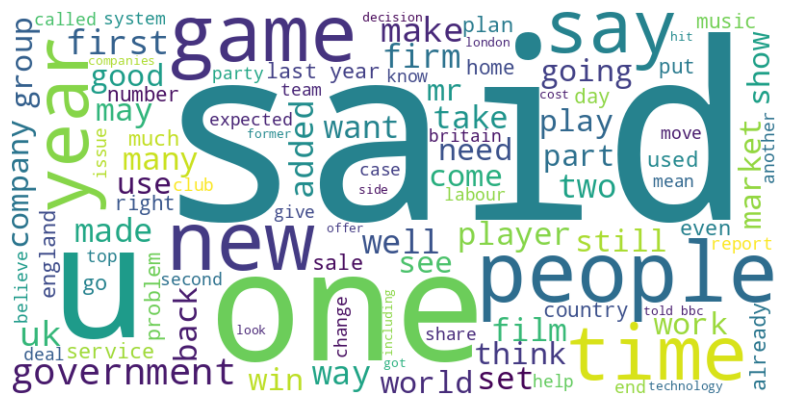

In [ ]:
# Konversi list corpus menjadi string
text = ' '.join(corpus)

# Konfigurasi WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)

# Tampilkan WordCloud menggunakan Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Build Machine Learning for NLP BBC News

In [ ]:
df_clean.head()

,content,business,entertainment,politics,sport,tech
0,quarterly profits us media giant timewarner ju...,1,0,0,0,0
1,dollar hit highest level euro almost three mon...,1,0,0,0,0
2,owners embattled russian oil giant yukos ask b...,1,0,0,0,0
3,british airways blamed high fuel prices drop p...,1,0,0,0,0
4,shares uk drinks food firm allied domecq risen...,1,0,0,0,0


In [ ]:
# divided data into X(text) and y(label)
X = df_clean.content.values
y = df_clean[['business', 'entertainment','politics','sport','tech']].values

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
# Check total train and test
print(X_train.shape)
print(X_test.shape)

(1673,)
(419,)


Tokenizer

In [ ]:
max_words = 50000  # maximum vocabulary size is 50000
tokenizer = Tokenizer(num_words=max_words, oov_token='x')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_len = 100  # maximum sequence length is 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, truncating='post')

In [ ]:
X_train_pad

array([[ 1043,  2880,   223, ..., 15978,   854,   362],
       [ 1044,   285,   109, ...,  2312,  5849,   264],
       [   12,   467,     9, ...,  1540,  2442,     8],
       ...,
       [  107,   157,   497, ...,   200,  1972,    56],
       [    0,   432,  3098, ...,   432,   199,   131],
       [15976,   475,   629, ...,   333, 25183, 10227]], dtype=int32)

In [ ]:
X_test_pad

array([[  645,   175,   389, ...,  3567,   134, 11195],
       [  187,   150,   359, ...,  2942,   864,   943],
       [ 2052,  5470,    74, ...,   328,   229,   839],
       ...,
       [  396,    75,   824, ...,   232,  1975,  1350],
       [   36,    43, 10867, ...,  2005,   176,    71],
       [  903,   453,  2863, ...,  3185,    15,  1193]], dtype=int32)

Training model

In [ ]:
# Callback
# stop training when accuracy train and val accuracy reach more than 90%
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9 and logs.get('val_loss') < 0.4):
            self.model.stop_training = True
            print("\nAkurasi dari training set dan validation set telah terpenuhi > 90%!")

callbacks = myCallback()

In [ ]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=32),
    LSTM(64, return_sequences=True),  # LSTM layer with 64 units and return_sequences=True
    GlobalAveragePooling1D(),  # Global average pooling layer
    Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
    Dropout(0.5),  # Dropout layer with a dropout rate of 0.5
    Dense(5, activation='softmax')  # Dense layer with 5 units (assuming it's a 5-class classification) and softmax activation
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          1600000   
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          24832     
                                                                 
 global_average_pooling1d_3  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                      

In [ ]:
num_epochs = 50  # define 50 epochs
history = model.fit(X_train_pad, y_train, epochs=num_epochs, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/50
53/53 - 10s - loss: 1.4652 - accuracy: 0.3909 - val_loss: 1.0556 - val_accuracy: 0.5871 - 10s/epoch - 193ms/step
Epoch 2/50
53/53 - 4s - loss: 0.8669 - accuracy: 0.6246 - val_loss: 0.8589 - val_accuracy: 0.5990 - 4s/epoch - 67ms/step
Epoch 3/50
53/53 - 3s - loss: 0.8489 - accuracy: 0.6246 - val_loss: 0.9345 - val_accuracy: 0.5800 - 3s/epoch - 55ms/step
Epoch 4/50
53/53 - 3s - loss: 0.6920 - accuracy: 0.6820 - val_loss: 0.7494 - val_accuracy: 0.7661 - 3s/epoch - 51ms/step
Epoch 5/50
53/53 - 2s - loss: 0.4667 - accuracy: 0.8392 - val_loss: 0.5401 - val_accuracy: 0.8305 - 2s/epoch - 45ms/step
Epoch 6/50
53/53 - 3s - loss: 0.1744 - accuracy: 0.9516 - val_loss: 0.3840 - val_accuracy: 0.8974 - 3s/epoch - 55ms/step
Epoch 7/50
53/53 - 2s - loss: 0.1058 - accuracy: 0.9815 - val_loss: 0.5716 - val_accuracy: 0.8592 - 2s/epoch - 37ms/step
Epoch 8/50
53/53 - 2s - loss: 0.1737 - accuracy: 0.9582 - val_loss: 0.7356 - val_accuracy: 0.8043 - 2s/epoch - 31ms/step
Epoch 9/50
53/53 - 1s - loss:

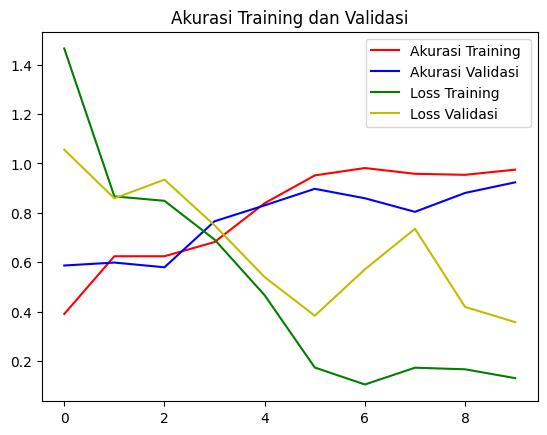

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Training ')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
plt.plot(epochs, loss, 'g', label='Loss Training ')
plt.plot(epochs, val_loss, 'y', label='Loss Validasi')

plt.title('Akurasi Training dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

Evaluating the model with test data.

In [ ]:
# Membuat list untuk menyimpan hasil prediksi
results = []

# Prediksi untuk 10 kalimat pertama dari X_test
for i in range(30):
    new_sentence = X_test[i]

    # Tokenize and pad the new sentence
    new_sentence_seq = tokenizer.texts_to_sequences([new_sentence])
    new_sentence_pad = pad_sequences(new_sentence_seq, maxlen=max_len, padding='post')

    # Melakukan prediksi menggunakan model
    predictions = model.predict(new_sentence_pad)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Mengonversi kelas prediksi menjadi label
    class_labels = ['business', 'entertainment', 'politics', 'sport', 'tech']  # label kelas aktual
    predicted_label = class_labels[predicted_class]

    # Mendapatkan label aktual dari data uji
    actual_label = class_labels[np.argmax(y_test[i])]

    # Menambahkan hasil prediksi ke list
    results.append({'Kalimat': new_sentence, 'Prediksi': predicted_label, 'Aktual': actual_label, 'Correct': predicted_label == actual_label})

# Membuat DataFrame dari list hasil prediksi
result_df = pd.DataFrame(results)

# Menampilkan DataFrame hasil prediksi
result_df

1/1 [==============================] - 0s 56ms/step


,Kalimat,Prediksi,Aktual,Correct
0,manchester united manager sir alex ferguson sa...,sport,sport,True
1,computer users across world continue ignore se...,tech,tech,True
2,rapper eminem play intimate gig london saturda...,entertainment,entertainment,True
3,thousands website bulletin boards defaced viru...,tech,tech,True
4,shares cairn energy rose pence tuesday uk firm...,business,business,True
5,michael howard launched attack cost britain ch...,politics,politics,True
6,one million computers net hijacked attack webs...,tech,tech,True
7,snow patrol big winners ireland top music hono...,entertainment,entertainment,True
8,householders injure even kill intruders unlike...,business,politics,False
9,jade johnson undecided whether contest next mo...,sport,sport,True


from 30 data, 5 of them are predicted incorrectly

#### Conclusions:
1. There are five categories for BBC news: sport, business, politics, tech, and entertainment, with a total of 2092 data points.
2. Preprocessing involves removing stop words, numbers, converting to lowercase, and removing punctuations.
3. Data is split into an 80:20 ratio for training and testing.
4. Tokenization is performed with a maximum of 50,000 words and a maximum sequence length of 100.
5. The accuracy threshold of >90% for both the training set and validation set has been achieved!
   - Training Loss: 0.1314, Training Accuracy: 97.49%
   - Validation Loss: 0.3580, Validation Accuracy: 92.36%